In [1]:
import pandas as pd
import sqlite3
import numpy as np

In [2]:
con = sqlite3.connect('data.db')
cur = con.cursor()

In [3]:
df = pd.read_csv("RMS_Crime_Incidents.csv")
df.to_sql('crimes', con = con, if_exists='replace')
df.head()

c:\Users\aleja\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,X,Y,crime_id,report_number,address,offense_description,offense_category,state_offense_code,arrest_charge,charge_description,...,year,scout_car_area,precinct,block_id,neighborhood,council_district,zip_code,longitude,latitude,oid
0,-83.178905,42.365775,3021501,1702050013,W Chicago St & Carlin Ave,ARSON,ARSON,2099,20000,ARSON,...,2017,0207,02,261635351002016,Plymouth-Hubbell,7,48227,-83.178905,42.365775,1
1,-83.100665,42.347159,3037178,1703120035,Merrick St & 23rd St,ARSON,ARSON,2099,20000,ARSON,...,2017,0304,03,261635221002020,Chadsey Condon,6,48208,-83.100665,42.347159,2
2,-83.205115,42.398099,3042208,1703240447,Hackett St & Mansfield St,ROBBERY,ROBBERY,1201,12000,ROBBERY,...,2017,0814,08,261635423002001,Grand River-St Marys,1,48227,-83.205115,42.398099,3
3,-82.981679,42.429053,3043540,1703280231,Gratiot Ave & Mapleridge St,"ACCIDENT, HIT & RUN",OUIL,5421,54001,"ACCIDENT, HIT & RUN",...,2017,0905,09,261635035002006,Franklin,4,48205,-82.981679,42.429053,4
4,-83.133678,42.359601,3044170,1703290408,Colfax St & S Martindale St,ARSON,ARSON,2099,20000,ARSON,...,2017,1006,10,261635337002008,Midwest,6,48204,-83.133678,42.359601,5


In [4]:
pct_20to21_query = """select cast(precinct as integer) as pct, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and incident_timestamp >= '2020/03/15 00:00:00+00' 
                        and incident_timestamp <= '2021/03/15 00:00:00+00'
                        group by pct"""
pct_21to22_query = """select cast(precinct as integer) as pct, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and incident_timestamp >= '2021/03/15 00:00:00+00' 
                        and incident_timestamp <= '2022/03/15 00:00:00+00'
                        group by pct"""
pct_since2016_query = """select cast(precinct as integer) as pct, year, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and year > 2016
                        group by pct, year
                        order by year, pct"""
since2016_bytreatment_query = """select CASE WHEN precinct <= 8 and precinct < 10 then 'ss_zone' else 'outside_ss_zone' end as ss_zone, year, count(distinct report_number) as cnt
                        from crimes 
                        where offense_category = 'WEAPONS OFFENSES'
                        and year > 2016
                        and precinct != 0
                        group by ss_zone, year
                        order by year, ss_zone"""


<AxesSubplot:title={'center':"Weapons offenses per precinct between Mar. '21 and Mar. '22"}, xlabel='pct'>

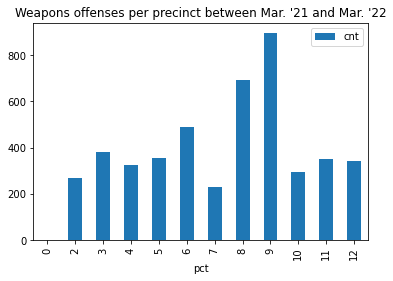

In [5]:
pct_21to22_df = pd.read_sql(pct_21to22_query, con)
pct_21to22_df.plot.bar(x = 'pct', y = 'cnt', title = "Weapons offenses per precinct between Mar. '21 and Mar. '22")

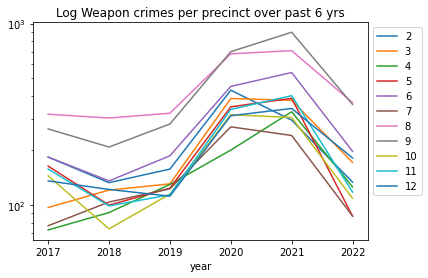

In [6]:
since2016_df = pd.read_sql(pct_since2016_query, con)
since2016_pvt = pd.pivot(since2016_df, columns = 'pct', values = 'cnt', index = 'year')
since2016_pvt.drop([0], axis = 1, inplace=True)
lines_2016 = since2016_pvt.plot.line(logy = True, title = 'Log Weapon crimes per precinct over past 6 yrs')
lines_2016.legend(bbox_to_anchor=(1.0, 1.0))

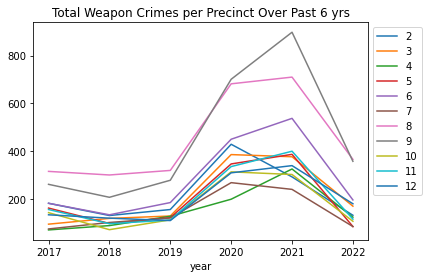

In [7]:
lines_2016 = since2016_pvt.plot.line(title = 'Total Weapon Crimes per Precinct Over Past 6 yrs')
lines_2016.legend(bbox_to_anchor=(1.0, 1.0))

In [8]:
since2016_bytreatment_df = pd.read_sql(since2016_bytreatment_query, con)
since2016_bytreatment_pvt = pd.pivot(since2016_bytreatment_df, columns = 'ss_zone', values = 'cnt', index = 'year')
since2016_bytreatment_pvt['ss_pct_change'] = since2016_bytreatment_pvt['ss_zone'].pct_change()
since2016_bytreatment_pvt['out_ss_pct_change'] = since2016_bytreatment_pvt['outside_ss_zone'].pct_change()
since2016_bytreatment_pvt

ss_zone,outside_ss_zone,ss_zone,ss_pct_change,out_ss_pct_change
year,,,,
2017,807,991,NaN,NaN
2018,883,608,-0.386478,0.094176
2019,1032,764,0.256579,0.168743
2020,2642,1791,1.344241,1.560078
2021,3711,1109,-0.380793,0.404618
2022,1165,775,-0.301172,-0.686068


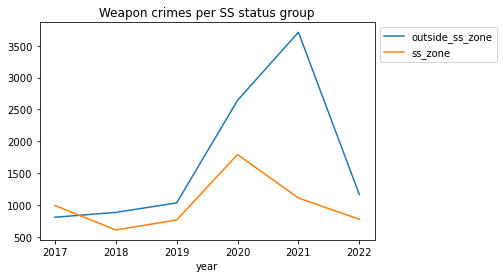

In [9]:
since2016_bytreatment_pvt.drop(['ss_pct_change', 'out_ss_pct_change'], axis = 1, inplace = True)
lines_2016_bytmt = since2016_bytreatment_pvt.plot.line(title = 'Weapon crimes per SS status group')
lines_2016_bytmt.legend(bbox_to_anchor=(1.0, 1.0))

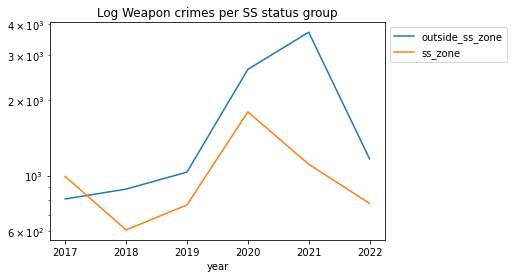

In [10]:
lines_2016_bytmt = since2016_bytreatment_pvt.plot.line(logy = True, title ='Log Weapon crimes per SS status group')
lines_2016_bytmt.legend(bbox_to_anchor=(1.0, 1.0))